In [ ]:
from BinanceTrade import *
from binance.client import Client
import pandas as pd
import numpy as np
import requests
import datetime
import openpyxl
import yaml

In [117]:
from BinanceTrade import *
import pandas as pd

ticker = "DOGEUSDT"
interval = "15m"
df = pd.read_csv(f"data/{ticker}/{ticker}{interval}.csv")
# start_date = datetime.datetime(2017, 1, 1)
# end_date = datetime.datetime.now()
# df=get_all_ohlcv(
#     symbol=ticker, 
#     interval=interval, 
#     start_date=start_date, 
#     end_date=end_date
#     )

# 초기 설정
start_balance =10000.0 # 시작 자산
fee = 0.0005    # 수수료
dca_levels = [0.3,0.5,1.0]      # 분할매수 비율
dca = -0.02 # 분할매수 진입 최소 수익률 
mtp = -1    # Min Take Profit 매도시 최소 수익률 (미사용 시 -1)
stl = -1    # Stop Loss (미사용 시 -1)
length=14
change_percentage=1.4
below=25
above=50

# 전략 설정
bt = srp_strategy(df=df,change_percentage=change_percentage,below=below,above=above)

# 백테스트 시작
bt['보유현금'] = 0.0
bt['보유수량'] = 0.0
bt['평균단가'] = 0.0
bt['현재수익률'] = 0.0
bt['총자산'] = 0.0
bt['총수익률'] = 0.0
cash = start_balance    # 보유현금
quantity = 0    # 보유수량
dca_level = 0   # 분할매수 횟수
ror = 0     # 수익률
pror = 0    # 직전매수가 대비 수익률 
buy_price = None    # 평균단가
pre_price = None    # 직전매수가
buy_pur = 0     # 매수 횟수
sell_pur = 0    # 매도 횟수
ar = []     # 청산 수익률 기록
for i in range(len(bt)):
    price = df.loc[i, 'Close']  # 현재가
    ror = (price-buy_price) / buy_price if buy_price != None else 0   # 수익률 계산
    pror = (price-pre_price) / pre_price if pre_price != None else -1
    if bt.loc[i, 'Action'] == 'Long' and dca_level < len(dca_levels) and pror < dca:
        rate = dca_levels[dca_level]    # 매수 비율
        buy_quantity = cash*rate / price*(1-fee)  # 매수수량 = 현금*비율 / 현재가*(1-수수료)
        if buy_price == None:   # 매수 평균가 조정
            buy_price = price
        else:
            buy_price = (buy_price*quantity + price*buy_quantity )/(quantity+buy_quantity)
        pre_price = price
        quantity += buy_quantity    # 수량 업데이트
        cash -= cash*rate   # 현금 업데이트
        dca_level += 1
        buy_pur += 1
        # print(f"{bt.loc[i, 'Time']} {buy_quantity*price}$ 매수!")
    elif bt.loc[i, 'Action'] == 'Short' and quantity > 0 and pror > mtp or pror < stl:
        rate = 1    # 매도 비율
        sell_quantity = quantity * rate     # 매도 수량
        cash += sell_quantity * price * (1-fee)     # 현금 업데이트 (수수료 포함)
        quantity -= sell_quantity   # 수량 업데이트
        dca_level = 0
        sell_pur += 1
        buy_price = None
        pre_price = None
        ar.append(ror)
        print(f"{bt.loc[i, 'Time']} (수익률: {round(ror*100,3)}%) {sell_quantity*price}$ 매도!")
    bt.loc[i, '보유현금'] = cash
    bt.loc[i, '보유수량'] = quantity
    bt.loc[i, '평균단가'] = buy_price
    bt.loc[i, '현재수익률'] = ror*100
    bt.loc[i, '총자산'] = cash + (quantity*price)
    bt.loc[i, '총수익률'] = ((bt.loc[i,'총자산'] - start_balance) / start_balance)*100


/var/folders/5n/y13cbnyn1t1352k1d37bjkym0000gn/T/ipykernel_45385/758210152.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt['보유현금'] = 0.0


2019-07-05 19:30:00 (수익률: 0.719%) 3020.045421015245$ 매도!
2019-07-06 12:45:00 (수익률: 0.517%) 3019.5790398538215$ 매도!
2019-07-06 23:45:00 (수익률: 1.175%) 6593.512730024276$ 매도!
2019-07-09 02:00:00 (수익률: 2.557%) 3106.268591160041$ 매도!
2019-07-09 16:30:00 (수익률: 1.254%) 3089.386862059183$ 매도!
2019-07-10 20:45:00 (수익률: -0.691%) 6587.75616127907$ 매도!
2019-07-11 12:00:00 (수익률: 0.93%) 6660.873697143104$ 매도!
2019-07-11 16:30:00 (수익률: 2.934%) 3152.179307547749$ 매도!
2019-07-11 21:15:00 (수익률: 2.247%) 6841.745328972636$ 매도!
2019-07-12 20:45:00 (수익률: 0.332%) 3141.805130858835$ 매도!
2019-07-15 03:30:00 (수익률: -3.405%) 10089.609573189666$ 매도!
2019-07-15 14:00:00 (수익률: 3.786%) 6799.7383435183765$ 매도!
2019-07-16 15:30:00 (수익률: 1.337%) 3137.641718531479$ 매도!
2019-07-16 20:45:00 (수익률: -1.122%) 6657.826156365707$ 매도!
2019-07-17 00:00:00 (수익률: 3.532%) 3191.9318147287645$ 매도!
2019-07-17 05:30:00 (수익률: 2.417%) 3190.0520822323942$ 매도!
2019-07-17 12:30:00 (수익률: 3.363%) 3241.8626009100203$ 매도!
2019-07-18 10:45:00 (수익률

In [116]:
print(f"{ticker} {interval}")
print(f"매수 횟수: {buy_pur}번")
print(f"매도 횟수: {sell_pur}번")
print(f"매매 평균 수익률: {(sum(ar)/len(ar))*100}%")
print(f"최고 수익률: {round(max(bt['총수익률']),3)}%")
print(f"MDD: {round(min(bt['현재수익률']),3)}%")
print(f"최종 수익률: {round(bt['총수익률'].iloc[-1],3)}%")

STXUSDT 15m
매수 횟수: 1624번
매도 횟수: 1029번
매매 평균 수익률: 1.5163164171127061%
최고 수익률: 1994.103%
MDD: -27.363%
최종 수익률: 1993.272%


In [104]:
# 엑셀로 출력
strategy_name = "SRP"
now = datetime.datetime.now()
bt.to_excel(f"backtest/[{strategy_name}]BackTest_{ticker}{interval}_{start_date.strftime('%Y%m%d')}~{end_date.strftime('%Y%m%d')}.xlsx")

/Users/ho/miniforge3/envs/ht/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ho/miniforge3/envs/ht/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ho/miniforge3/envs/ht/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ho/miniforge3/envs/ht/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


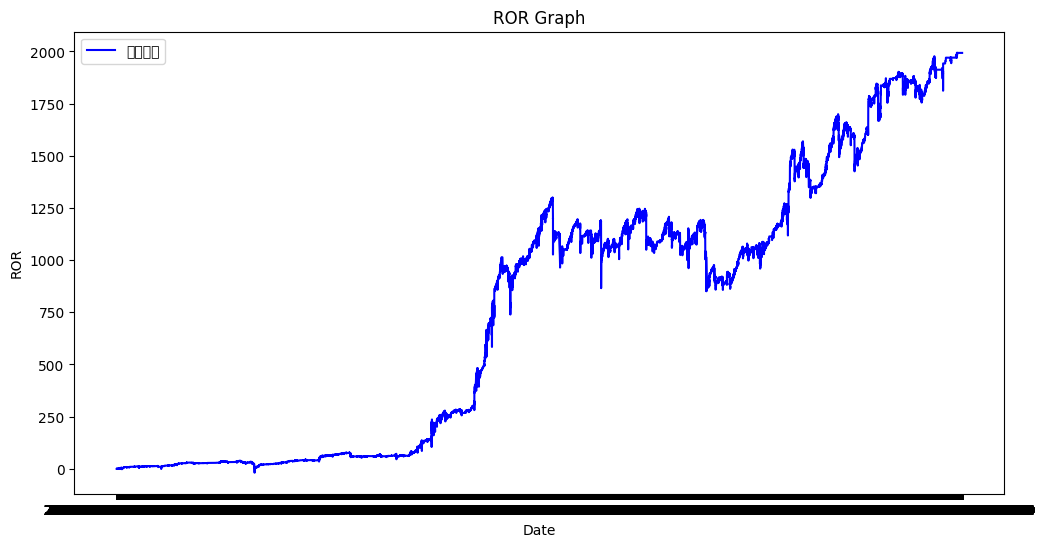

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("backtest/[SRP]BackTest_DOGEUSDT15m_20170101~20230921.xlsx")
# 그래프 그리기
plt.figure(figsize=(12, 6))  # 그래프의 크기 설정 (선택적)
plt.plot(df['Time'], df['총수익률'], label='총수익률', color='b', linestyle='-')

# 그래프 제목과 레이블 설정 (선택적)
plt.title('ROR Graph')
plt.xlabel('Date')
plt.ylabel('ROR')

# 그래프 범례 추가 (선택적)
plt.legend()

# 그래프 표시
plt.show()